# 6. 數據分析專案
# Demo2 - Backtesting

### Import data and add MA20 and MA60

In [1]:
import pandas as pd
import numpy as np
import math
import yfinance as yf
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

df_cola = yf.download('KO', start='2022-04-08',
                      end='2023-01-01', auto_adjust=True)

[*********************100%%**********************]  1 of 1 completed


In [2]:
for i in [20,60]:
    df_cola[f"MA_{i}"] = df_cola["Close"].rolling(i).mean()
df_cola = df_cola.dropna()
df_cola.sample(3)

,Open,High,Low,Close,Volume,MA_20,MA_60
Date,,,,,,,
2022-10-17,54.403430,54.980422,54.344752,54.462105,13721400,55.290432,59.199772
2022-10-05,55.254247,55.400941,54.286073,54.999981,14324900,57.487852,60.047528
2022-10-10,53.396138,53.748201,52.828928,53.190769,10239100,56.428881,59.692596


### Plot a general technical chart with plotly

In [3]:
fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                    vertical_spacing=0.01, row_heights=[0.7,0.3])
fig.add_trace(go.Candlestick(x=df_cola.index,
                             open=df_cola['Open'], high=df_cola['High'],
                             low=df_cola['Low'], close=df_cola['Close'],
                             showlegend=True, name='Close Price'),row=1,col=1)
fig.add_scatter(x=df_cola.index, y=df_cola['MA_20'], name='MA20')
fig.add_scatter(x=df_cola.index, y=df_cola['MA_60'], name='MA60')
fig.add_trace(go.Bar(x=df_cola.index, y=df_cola.Volume,
                     showlegend=True, name='Volume',
                     marker=dict(color='rgb(125,125,222)')),row=2,col=1)
fig.update_layout(title="CocaCola Share Price (Close) US$",
                  xaxis_rangeslider_visible=False)
fig.show()

#### Principal of MA indicator

As most of you already knew, the fast MA20 raise over slow MA60 is a buy
signal, whereas MA60 raise over MA20 is a sell signal. With this strategy, we
can backtest with historic data.

### Write a simple function to raise signal

This function will compare the two MA. Return 1 of MA20 is higher, -1 of MA60 is  
higher. 0 means they are equal.

In [4]:
def indicator(row): #fastMA, slowMA
    if row.MA_20 > row.MA_60 :
        signal = 1
    elif row.MA_20 < row.MA_60 :
        signal = -1
    else:
        signal = 0
    return signal

### Df.apply()

Use function df.apply() to return the signal in pd.Series. We can see when they change
situation. From -1 to 1, or from 1 to -1. BUT we still need to compare the previous date’s
indicators. So we shall
do one more step.

In [5]:
df_cola[['MA_20','MA_60']].apply(indicator, axis=1)

Date
2022-07-06   -1
2022-07-07   -1
2022-07-08   -1
2022-07-11   -1
2022-07-12   -1
             ..
2022-12-23    1
2022-12-27    1
2022-12-28    1
2022-12-29    1
2022-12-30    1
Length: 125, dtype: int64

### Using nested np.where()

We use np.where() to set condition to discover the change from shifting(previous)
indicators. Indicator.shift(1) means the yesterday(T-1) Indicator.

In [6]:
df_i = pd.DataFrame({"Indicator": df_cola[['MA_20','MA_60']].apply(indicator, axis=1) })
np.where((df_i.Indicator==1)&(df_i.Indicator.shift(1)==-1), "B",
         np.where((df_i.Indicator==-1)&(df_i.Indicator.shift(1)==1), "S", "Hold"))

array(['Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold',
       'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'B', 'Hold',
       'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold',
       'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold',
       'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold',
       'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold',
       'Hold', 'S', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold',
       'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold',
       'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold',
       'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold',
       'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold',
       'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'B', 'Hold', 'Hold',
       'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold',
       'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold', 'Hold',
       'Hold', 

In [7]:
df_i['Action'] = np.where((df_i.Indicator==1)&(df_i.Indicator.shift(1)==-1), "B",
                          np.where((df_i.Indicator==-1)&(df_i.Indicator.shift(1)==1), "S", "Hold"))
# Check the Action with chart

In [8]:
df_i.loc[df_i['Action']=='B']

,Indicator,Action
Date,,
2022-07-26,1,B
2022-11-15,1,B


In [9]:
df_i.loc[df_i['Action']=='S']

,Indicator,Action
Date,,
2022-09-14,-1,S


### Simplify work flow

The Indicator and Action condition logics could be simplified as follow. We may use
this function to test many more combination later. 0 means hold, 1 buy, -1 sell.

In [10]:
fastma = f'MA_20'
slowma = f'MA_60'

def signal(df, fastma, slowma):
    return np.where((df[fastma]>df[slowma])&(df[fastma].shift(1)<df[slowma].shift(1)), 1,
            np.where((df[fastma]<df[slowma])&(df[fastma].shift(1)>df[slowma].shift(1)), -1, 0))

In [11]:
signal(df_cola, fastma, slowma).tolist()

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

### DF index warning

In [12]:
df_strategy = df_cola[['Close']]

In [13]:
df_strategy["Signal"] = signal(df_cola, fastma, slowma).tolist()
# Sometimes while we add a new column without index, it warns us as the above. It is
# because Pandas confuse how properly to add the new column.

C:\Users\User\AppData\Local\Temp\ipykernel_20568\1133597063.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



We just need to specify as the original df.index to add new Series data.
Furthermore we add two more columns with NaN for further use.

In [14]:
df_strategy.loc[df_strategy.index, ["Signal"]] = signal(df_cola, fastma, slowma).tolist()

In [15]:
df_strategy.loc[df_strategy.index,['Cash']] = np.NaN
df_strategy.loc[df_strategy.index,['Stock']] = np.NaN

In [16]:
df_strategy

,Close,Signal,Cash,Stock
Date,,,,
2022-07-06,61.563046,0,NaN,NaN
2022-07-07,61.077610,0,NaN,NaN
2022-07-08,61.300907,0,NaN,NaN
2022-07-11,61.106731,0,NaN,NaN
2022-07-12,60.844597,0,NaN,NaN
...,...,...,...,...
2022-12-23,62.855495,0,NaN,NaN
2022-12-27,63.239597,0,NaN,NaN
2022-12-28,62.609272,0,NaN,NaN


Check the simplified code with chart.

In [17]:
# buy signal
df_strategy.loc[df_strategy['Signal']==1]

,Close,Signal,Cash,Stock
Date,,,,
2022-07-26,61.368870,1,NaN,NaN
2022-11-15,59.293186,1,NaN,NaN


In [18]:
# buy signal
df_strategy.loc[df_strategy['Signal']==-1]

,Close,Signal,Cash,Stock
Date,,,,
2022-09-14,59.01936,-1,NaN,NaN


#### Avoid directly use loop over DF or Series

Pandas DF is vectorized and able to implement fast. While we
need to handle data rows to rows, we should prioritize to use:
1. built-in function
2. df.iterrows, df.itertuples, or df.items
3. list comprehension

### Backtest function

Now we write a backtest function for our strategy_df.
Also set up some variables.

In [19]:
def backtest(df, cash=1.0, comm_rate = 0.0, stock = 0.0, rf_rate = 0.01):
    """Backtest given strategy DF"""
    """row[0] os Close price; row[1] is Signal; """
    """Signal=1 means buy; Signal=-1 means sell """
    cash_init = cash

### Using df.iterrows()

Write a for loop using df.iterrows(), to update buy/sell/hold of stock and cash columns.

In [20]:
def backtest(df, cash=1.0, comm_rate = 0.0, stock = 0.0, rf_rate = 0.01):
    """Backtest given strategy DF"""
    """row[0] os Close price; row[1] is Signal; """
    """Signal=1 means buy; Signal=-1 means sell """
    cash_init = cash
    for i, row in df.iterrows(): # i is index, row is row in df
        # buy signal
        if row[1]==1:
            stock = (cash / row[0]) * (1 - comm_rate)
            comm = cash / row[0] * comm_rate
            cash = 0
            df.at[i,'Cash'] = cash # To avoid index warning, use df.at[ ] or df.iat[ ]
            df.at[i,'Stock'] = stock
            print(f"{i}> Bought {stock:.4f}share @${row[0]:.4f}, Comm:{comm:.2f}, Cash Bal.:{cash:.4f}")
            
        # sell signal
        elif row[1]==-1:
            cash = stock * row[0] * (1 - comm_rate)
            comm = stock * row[0] * comm_rate
            # Print buy/sell record while signal raised
            print(f"{i}> Sold {stock:.4f}share @${row[0]:.4f}, Comm:{comm:.2f}, Cash Bal.:{cash:.4f}")
            stock = 0
            df.at[i,'Cash'] = cash
            df.at[i,'Stock'] = stock
            
        # hold
        else:
            df.at[i,'Cash'] = cash
            df.at[i,'Stock'] = stock
            
## It is possible that it didn’t trigger sell signal at the period last day. We need to force  
## liquidate stock to cash at the end of date.

    # force cash out at the end and term if still stock
    if stock >=0:
        cash = stock * df.iat[-1,0] * (1 - comm_rate)
        comm = stock * df.iat[-1,0] * comm_rate
        print(f"Force selling @${df.iat[-1,0]:4f} at end term. Cash Bal.:{cash:.4f}")
        stock = 0 
        df.at[i,'Cash'] = cash
        df.at[i,'Stock'] = stock

### Print out summary
        
## Finally we print out a summary and return a list of key figures.

    # summary output
    simple_rtn = (cash - cash_init)/cash_init
    trading_times = df.loc[(df['Signal']==1) | (df['Signal']==-1)].shape[0]
    holding_days = df[df['Stock']>0].shape[0]
    total_days = df.shape[0]
    df.loc[df.index, ['Amount']] = [x[2] + x[3]*x[0] for x in np.array(df)]
    df.loc[df.index, ['Daily_rtn']] = df['Amount'].pct_change()
    std = df_strategy['Daily_rtn'].std()
    sharpe = (simple_rtn - rf_rate) / std / np.sqrt(total_days) * np.sqrt(250) # annualized sharpe ratio
    print(f"Sharpe:{sharpe:.4f}, Return:{simple_rtn*100:.4}%, SD:{std:.5f}")
    print(f"Transaction times:{trading_times}, hold {holding_days}days, total period:{total_days}days")
    
    return [sharpe, simple_rtn, std, trading_times, holding_days, total_days]

### Run backtest

Run backtest function, we get the following result. To implement more combinations,
we need to gather those key numbers at last.

In [21]:
backtest(df_strategy)

2022-07-26 00:00:00> Bought 0.0163share @$61.3689, Comm:0.00, Cash Bal.:0.0000
2022-09-14 00:00:00> Sold 0.0163share @$59.0194, Comm:0.00, Cash Bal.:0.9617
2022-11-15 00:00:00> Bought 0.0162share @$59.2932, Comm:0.00, Cash Bal.:0.0000
Force selling @$62.648670 at end term. Cash Bal.:1.0161
Sharpe:1.2349, Return:1.614%, SD:0.00703
Transaction times:3, hold 66days, total period:125days


[1.2349488251058378, 0.0161397397528662, 0.007030982216773614, 3, 66, 125]

The df_strategy looks like this after our final update. It should be
erased for large amount of testing.

In [22]:
df_strategy.sample(5)

,Close,Signal,Cash,Stock,Amount,Daily_rtn
Date,,,,,,
2022-07-08,61.300907,0,1.0,0.000000,1.000000,0.000000
2022-11-25,61.307766,0,0.0,0.016220,0.994391,0.000958
2022-07-27,61.174698,0,0.0,0.016295,0.996836,-0.003164
2022-12-09,62.185768,0,0.0,0.016220,1.008632,-0.010500
2022-11-29,61.102394,0,0.0,0.016220,0.991060,-0.003509


## Mini Project – Backtest various of MA indicators

### Pair up combination

Write a function to pair up the needed combination. There are 2556 pairs MA.

In [23]:
def pairup(min_MA=20, max_MA=100, interv=10):
    counter = 0
    fast_MA, slow_MA = min_MA, min_MA+interv # initiate combination MAs
    comb_list = []
    
    for f in range(min_MA, max_MA-interv+1):
        for s in range(f+interv, max_MA+1):
            comb_list.append([f,s])
            slow_MA += 1
            counter += 1
            
        fast_MA += 1
    
    print(f"Total combinations: {counter}")
    return comb_list

comb_list = pairup()

Total combinations: 2556


### Checking pairs

Check the first 7 and last 7 pairs.

In [24]:
comb_list[0:7]

[[20, 30], [20, 31], [20, 32], [20, 33], [20, 34], [20, 35], [20, 36]]

In [25]:
comb_list[-7:]

[[87, 100], [88, 98], [88, 99], [88, 100], [89, 99], [89, 100], [90, 100]]

In [26]:
len(comb_list)

2556

### Prepare a larger DF

Now we need a larger
DF consists of more
historic data.

In [27]:
import yfinance as yf
df_cola = yf.download('KO', start='2003-01-01',
                      end='2023-01-01', auto_adjust=True)

for i in range(20, 101):
    df_cola[f"MA_{i}"] = df_cola["Close"].rolling(i).mean()
df_cola = df_cola.dropna()
df_cola.sample(3)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Volume,MA_20,MA_21,MA_22,MA_23,MA_24,...,MA_91,MA_92,MA_93,MA_94,MA_95,MA_96,MA_97,MA_98,MA_99,MA_100
Date,,,,,,,,,,,,,,,,,,,,,
2018-05-21,35.857174,36.035145,35.823274,35.941921,9110200,35.845308,35.913269,35.965806,36.034778,36.105063,...,37.238619,37.255987,37.270904,37.286130,37.301123,37.310203,37.319962,37.332437,37.343302,37.355714
2004-02-03,13.830750,13.981753,13.791601,13.934216,7749600,13.923594,13.931823,13.938542,13.949539,13.956940,...,13.219615,13.207275,13.194663,13.182141,13.171113,13.158604,13.146095,13.135489,13.126474,13.119004
2019-06-07,45.124456,45.755688,45.106921,45.141991,15293600,43.361823,43.275842,43.215610,43.166334,43.138333,...,41.500629,41.495152,41.491661,41.491203,41.496061,41.495839,41.494636,41.488579,41.481416,41.480045


In [28]:
df_cola.shape

(4936, 86)

#### addd

In [29]:
def indicator(row): #fastMA, slowMA
    if row.MA_20 > row.MA_60 :
        signal = 1
    elif row.MA_20 < row.MA_60 :
        signal = -1
    else:
        signal = 0
    return signal
df_cola[['MA_20','MA_60']].apply(indicator, axis=1)


Date
2003-05-27    1
2003-05-28    1
2003-05-29    1
2003-05-30    1
2003-06-02    1
             ..
2022-12-23    1
2022-12-27    1
2022-12-28    1
2022-12-29    1
2022-12-30    1
Length: 4936, dtype: int64

In [30]:
import pandas as pd
import numpy as np
df_i = pd.DataFrame({"Indicator": df_cola[['MA_20','MA_60']].apply(indicator, axis=1) })
np.where((df_i.Indicator==1)&(df_i.Indicator.shift(1)==-1), "B",
         np.where((df_i.Indicator==-1)&(df_i.Indicator.shift(1)==1), "S", "Hold"))
df_i['Action'] = np.where((df_i.Indicator==1)&(df_i.Indicator.shift(1)==-1), "B",
                          np.where((df_i.Indicator==-1)&(df_i.Indicator.shift(1)==1), "S", "Hold"))
df_i.loc[df_i['Action']=='B']
df_i.loc[df_i['Action']=='S']

,Indicator,Action
Date,,
2003-07-25,-1,S
2004-03-11,-1,S
2004-07-21,-1,S
2005-04-06,-1,S
2005-07-01,-1,S
2005-09-28,-1,S
2005-12-14,-1,S
2006-04-24,-1,S
2007-02-14,-1,S


In [31]:
def comb(min_MA=20, max_MA=100, interv=10):
    counter = 0
    fast_MA, slow_MA = min_MA, min_MA+interv # initiate combination MAs
    comb_list = []
    
    for f in range(min_MA, max_MA-interv+1):
        for s in range(f+interv, max_MA+1):
            comb_list.append([f,s])
            slow_MA += 1
            counter += 1
            
        fast_MA += 1
    
    print(f"Total combinations: {counter}")
    return comb_list

comb_list = comb()

Total combinations: 2556


In [32]:
fastma = f'MA_20'
slowma = f'MA_60'
df=df_cola
def signal(df, fastma, slowma):
    return np.where((df[fastma]>df[slowma])&(df[fastma].shift(1)<df[slowma].shift(1)), 1,
            np.where((df[fastma]<df[slowma])&(df[fastma].shift(1)>df[slowma].shift(1)), -1, 0))

signal(df_cola, fastma, slowma).tolist()


df_strategy = df_cola[['Close']]
df_strategy.loc[df_strategy.index, ["Signal"]] = signal(df_cola, fastma, slowma).tolist()
df_strategy.loc[df_strategy.index,['Cash']] = np.NaN
df_strategy.loc[df_strategy.index,['Stock']] = np.NaN

### tqdm

tqdm is a progress bar library that handle iteration progress. In running large amount of
data, you would like to know the progress and make sure system is not hang.

In [33]:
from tqdm.notebook import tqdm_notebook
import time
for i in tqdm_notebook(range(10)):
    time.sleep(0.5)

  0%|          | 0/10 [00:00<?, ?it/s]

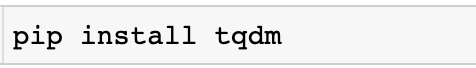
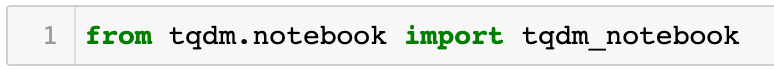
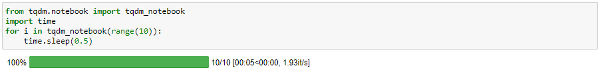

### Prepare large testing

Revised back_test function

In [34]:
# Utilities functions

def back_test(df, cash=1.0, comm_rate = 0.0, stock = 0.0, rf_rate = 0.01):
    """Backtest given strategic DF"""
    """Signal=1 means buy; Signal=-1 mean sell"""
    """row[0] is Close price; row[1] is Signal; """
    cash_init = cash
    trading_times = 0
    for i, row in df.iterrows():
        # buy signal
        if (row['Signal']==1) and (cash>0):
            stock = (cash * (1 - comm_rate)) / row[0]
            comm = cash * comm_rate
            cash = 0
            df.at[i,'Cash'] = cash
            df.at[i,'Stock'] = stock
            df.at[i,'Comm'] = comm
            trading_times += 1
            # print(f"{i}> Bought {stock:.4f}share @${row[0]:.4f}, Comm:{comm:.2f}, Cash Bal.:{cash:.4f})
            
### Prepare large testing
## Revised back_test function

        # sell signal
        elif (row['Signal']==-1) and (stock>0) :
            cash = stock * row['Close'] * (1 - comm_rate)
            comm = stock * row['Close'] * comm_rate
            #print(f"{i}> Sold {stock:.4f}share @${row[0]:.4f},{comm:.2f}, Cash Bal.:{cash:.4f})
            stock = 0
            df.at[i,'Cash'] = cash
            df.at[i,'Stock'] = stock
            df.at[i,'Comm'] = comm
            trading_times += 1
            
        # hold
        else:
            df.at[i,'Cash'] = cash
            df.at[i,'Stock'] = stock
            
    # force cash out at the end term if still held stock
    if stock > 0:
        cash = stock * df.iat[-1,0] * (1 - comm_rate)
        comm = stock * df.iat[-1,0] * comm_rate
        #print(f"Force selling @${df.iat[-1,0]:.4f} at end term. CAsh Bal.:{cash:.4f}")
        stock = 0
        df.at[i,'Cash'] = cash
        df.at[i,'Stock'] = stock
        df.at[i,'Comm'] = comm
        trading_times += 1
        
    # summary output
    holding_days = df[df['Stock']>0].shape[0]
    total_days = df.shape[0]
    df.loc[df.index, ['Amount']] = [x[2] + x[3]*x[0] for x in np.array(df)]
    df.loc[df.index, ['Daily_rtn']] = np.log(df['Amount']/df['Amount'].shift(1)) # daoly log return
    std = df['Daily_rtn'].tail(250).std()
    comm = df['Comm'].sum()
    simple_rtn = df['Amount'][-1]/df['Amount'][0] - 1
    sharpe = ((df['Amount'][-1]/df['Amount'][-251]-1-rf_rate)/np.sqrt(250))/std # twailing 250 days' sharpe ratio
    
    return[sharpe, simple_rtn, std, trading_times, holding_days, total_days, comm]

In [35]:
back_test(df_cola)

KeyError: 'Signal'

Create a DF to store testing result

In [ ]:
for c in comb_list:
    # print(c[0])
    # print(type(c[1]))
    # print(c)
    print(type(f'MA_{c[1]}'))

In [ ]:
##### This is new #####
import pandas as pd
import numpy as np
import math
import yfinance as yf
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm.notebook import tqdm_notebook
import time

def pairup(min_MA=20, max_MA=100, interv=10):
    counter = 0
    fast_MA, slow_MA = min_MA, min_MA+interv # initiate combination MAs
    comb_list = []
    
    for f in range(min_MA, max_MA-interv+1):
        for s in range(f+interv, max_MA+1):
            comb_list.append([f,s])
            slow_MA += 1
            counter += 1
            
        fast_MA += 1
    
    print(f"Total combinations: {counter}")
    return comb_list

comb_list = pairup()

import yfinance as yf
df_cola = yf.download('KO', start='2003-01-01',
                      end='2023-01-01', auto_adjust=True)

for i in range(20, 101):
    df_cola[f"MA_{i}"] = df_cola["Close"].rolling(i).mean()
df_cola = df_cola.dropna()

def signal(df, fastma, slowma):
    return np.where((df[fastma]>df[slowma])&(df[fastma].shift(1)<df[slowma].shift(1)), 1,
            np.where((df[fastma]<df[slowma])&(df[fastma].shift(1)>df[slowma].shift(1)), -1, 0))

Total combinations: 2556
[*********************100%%**********************]  1 of 1 completed


In [ ]:
##### This is new #####
# create df to store each comparason data
result = pd.DataFrame(columns=['Pairs','Sharpe','Simple_rtn','STD','Trading_times',
                               'Holding_days','Total_days','Comm'])
result = result.set_index(['Pairs'])

for c in tqdm_notebook(comb_list):
    # create df for temp input signal data for comparason each time
    # try:
    #     del df_strategic
    # except:
    #     pass
    df_strategic = df_cola[['Close']]
    
    # run each pair of test and build buy/sell/hold signal
    df_strategic.loc[df_strategic.index, ["Signal"]] = signal(df_cola, f"MA_{c[0]}", f"MA_{c[1]}").tolist()
    
    # set record for Cash and Stock
    df_strategic.loc[df_strategic.index,['Cash']] = np.NaN
    df_strategic.loc[df_strategic.index,['Stock']] = np.NaN
    df_strategic.loc[df_strategic.index,['Comm']] = 0
    
    # run test and get result
    ma_test = back_test(df_strategic)
    
    # keep result of sharpe, simple_rtn, std, trading_times, holding_days, total_days
    result.loc[f"MA_{c[0]}" f"MA_{c[1]}"] = ma_test
    
### The test could take around an hour. Make sure your computer stay in processing
### mode. And run the code to save as CSV.

result.sample(5)

  0%|          | 0/2556 [00:00<?, ?it/s]

,Sharpe,Simple_rtn,STD,Trading_times,Holding_days,Total_days,Comm
Pairs,,,,,,,
MA_62MA_78,-0.242582,1.458332,0.010480,88.0,3114.0,4936.0,0.0
MA_69MA_88,0.017004,1.797810,0.010457,70.0,3137.0,4936.0,0.0
MA_32MA_99,-0.014912,1.411921,0.010680,52.0,3198.0,4936.0,0.0
MA_45MA_91,-0.399346,1.133340,0.010783,58.0,3145.0,4936.0,0.0
MA_64MA_97,0.113178,1.496488,0.010378,56.0,3241.0,4936.0,0.0


In [ ]:
print(f'MA_{c[1]}')
print(ma_test)

Loop combination list for test

In [ ]:
from tqdm.notebook import tqdm_notebook
for c in tqdm_notebook(comb_list):
    # create df for temp input signal data for comparason each time
    try:
        del df_strategic
    except:
        pass
    df_strategic = df_cola[['Close']]
    
    # run each pair of test and build buy/sell/hold signal
    df_strategic.loc[df_strategic.index, ["Signal"]] = signal(df_cola, c[0], c[1]).tolist()
    
    # set record for Cash and Stock
    df_strategic.loc[df_strategic.index,['Cash']] = np.NaN
    df_strategic.loc[df_strategic.index,['Stock']] = np.NaN
    df_strategic.loc[df_strategic.index,['Comm']] = 0
    
    # run test and get result
    ma_test = back_test(df_strategic)
    
    # keep result of sharpe, simple_rtn, std, trading_times, holding_days, total_days
    result.loc[f"MA_{c[0]} MA_{c[1]}"] = ma_test
    
### The test could take around an hour. Make sure your computer stay in processing
### mode. And run the code to save as CSV.

result.sample(5)

In [ ]:
result.sample(5, replace=True)

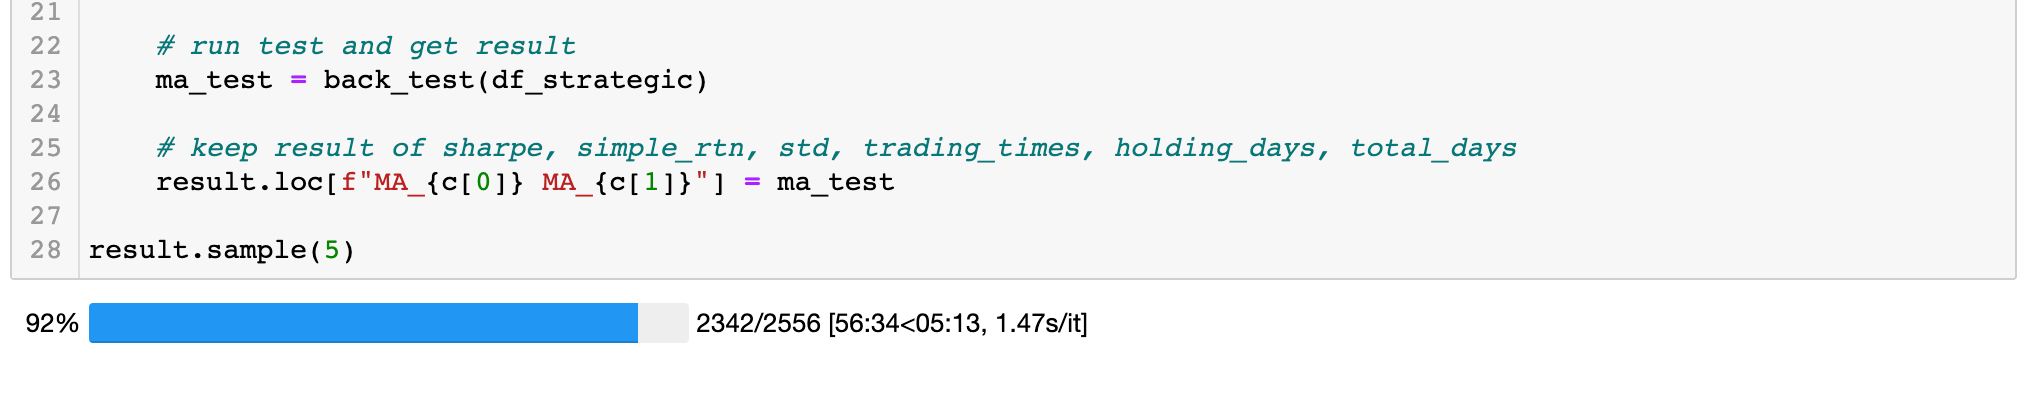

In [ ]:
result.to_csv("result1.csv")

In [ ]:
result

,Sharpe,Simple_rtn,STD,Trading_times,Holding_days,Total_days,Comm
Pairs,,,,,,,
MA_20MA_30,-0.129046,0.022893,0.009751,218.0,2916.0,4936.0,0.0
MA_20MA_31,-0.158229,0.148675,0.009755,202.0,2934.0,4936.0,0.0
MA_20MA_32,0.137921,0.099923,0.009951,190.0,2955.0,4936.0,0.0
MA_20MA_33,0.211510,0.194130,0.010014,194.0,2967.0,4936.0,0.0
MA_20MA_34,0.232058,0.286113,0.010045,176.0,2978.0,4936.0,0.0
...,...,...,...,...,...,...,...
MA_88MA_99,0.560491,1.060841,0.010458,74.0,3290.0,4936.0,0.0
MA_88MA_100,0.415511,1.143897,0.010353,68.0,3285.0,4936.0,0.0
MA_89MA_99,0.400713,1.100507,0.010354,78.0,3295.0,4936.0,0.0
